In [1]:
"""
A plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.
"""

'\nA plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.\n'

In [2]:
# This allows you to edit.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from src.smalldiffusion.model import TimeInputMLP
from src.smalldiffusion.diffusion import ScheduleLogLinear, training_loop, samples
from animations import animate_diffusion

/home/hevra/anaconda3/envs/prob_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hevra/anaconda3/envs/prob_diffusion/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/hevra/anaconda3/envs/prob_diffusion/lib/python3.12/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch, filename, save=False):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

    if save:
        # Save the plot to the specified path
        plt.savefig(filename)

    # Display the plot
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

In [4]:
# Define mean and variance, where the variance is unit and the means are significantly different.
mean_1 = 0.0
variance_1 = 1.0

mean_2 = 20
variance_2 = 1.0

mean_3 = -20
variance_3 = 1.0

In [5]:
# Generate samples
samples_group_1 = np.random.normal(loc=mean_1, scale=variance_1**0.5, size=20)  
samples_group_2 = np.random.normal(loc=mean_2, scale=variance_2**0.5, size=20)  
samples_group_3 = np.random.normal(loc=mean_3, scale=variance_3**0.5, size=20)  

# concatenate them
samples_combined = []
samples_combined.extend(samples_group_1)
samples_combined.extend(samples_group_2)
samples_combined.extend(samples_group_3)

In [6]:
print(len(samples_combined))
print(samples_group_1)
print(samples_group_2)
print(samples_group_3)

60
[-1.78764714  0.23998025  0.67873291 -0.89269741  0.92338453  0.80581388
 -0.08004028 -1.11966221 -1.27569084  1.14598632  0.85822452  0.76634804
 -0.06117988 -2.02868894 -1.0477922  -2.16928603 -0.22113321  0.8268233
  0.1273351  -2.31232962]
[19.61425329 18.93410706 21.17886446 19.91557408 19.58961455 18.84527258
 20.29416626 20.79379529 19.90232606 19.93818826 19.9753735  20.18843755
 20.69186628 19.28296551 20.29619528 20.41968229 18.68393712 21.72705078
 19.38699395 20.22684143]
[-21.31442877 -18.66904815 -19.32590883 -20.14224129 -20.70119306
 -19.4814968  -20.28955855 -19.68561495 -18.00628576 -19.63185204
 -19.99531388 -19.71637414 -19.63798102 -19.44818133 -20.39808988
 -20.16796907 -19.33284805 -19.34940502 -19.63636946 -19.61287021]


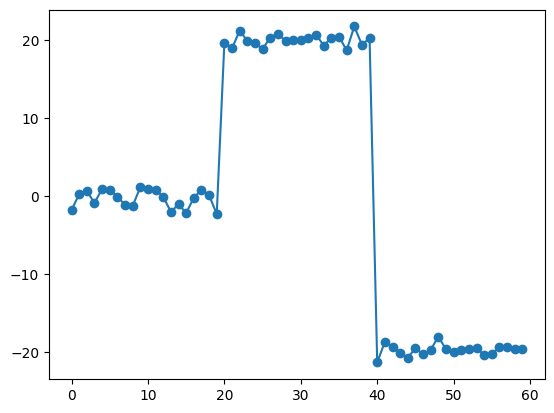

In [7]:
# Plot the values
plt.plot(samples_combined, marker='o')

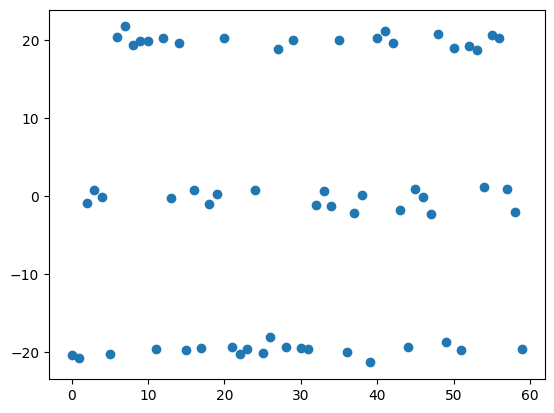

In [8]:
# Shuffle the list
shuffled_list = random.sample(samples_combined, len(samples_combined))

# Generate corresponding x-values
x_values = list(range(len(samples_combined)))

# Plot the values as points
plt.scatter(x_values, shuffled_list)

In [9]:
class GaussDistribution2D(Dataset):
    def __init__(self, mean, covariance_matrix, num_samples):

        # Sample from 3 different distributions
        samples_1 = np.random.multivariate_normal(mean[0], covariance_matrix, num_samples//3).astype(np.float32)
        samples_2 = np.random.multivariate_normal(mean[1], covariance_matrix, num_samples//3).astype(np.float32)
        samples_3 = np.random.multivariate_normal(mean[2], covariance_matrix, num_samples//3).astype(np.float32)

        samples_combined = []
        samples_combined.extend(samples_1)
        samples_combined.extend(samples_2)
        samples_combined.extend(samples_3)
        self.vals = samples_combined

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]
    

In [10]:
mean = [[0,0], [20,20], [-20,-20]]
covariance_matrix = [[1.0, 0.0], [0.0, 1.0]]  # Zero covariance
num_samples = 100
dataset = GaussDistribution2D(mean, covariance_matrix, num_samples)

loader = DataLoader(dataset, batch_size=2048)

In [11]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


tensor([5.0000e-03, 5.1947e-03, 5.3969e-03, 5.6070e-03, 5.8254e-03, 6.0522e-03,
        6.2878e-03, 6.5326e-03, 6.7870e-03, 7.0512e-03, 7.3257e-03, 7.6110e-03,
        7.9073e-03, 8.2151e-03, 8.5350e-03, 8.8673e-03, 9.2125e-03, 9.5712e-03,
        9.9439e-03, 1.0331e-02, 1.0733e-02, 1.1151e-02, 1.1585e-02, 1.2036e-02,
        1.2505e-02, 1.2992e-02, 1.3498e-02, 1.4023e-02, 1.4569e-02, 1.5136e-02,
        1.5726e-02, 1.6338e-02, 1.6974e-02, 1.7635e-02, 1.8322e-02, 1.9035e-02,
        1.9776e-02, 2.0546e-02, 2.1346e-02, 2.2177e-02, 2.3041e-02, 2.3938e-02,
        2.4870e-02, 2.5838e-02, 2.6844e-02, 2.7889e-02, 2.8975e-02, 3.0103e-02,
        3.1275e-02, 3.2493e-02, 3.3758e-02, 3.5072e-02, 3.6438e-02, 3.7856e-02,
        3.9330e-02, 4.0862e-02, 4.2452e-02, 4.4105e-02, 4.5823e-02, 4.7607e-02,
        4.9460e-02, 5.1386e-02, 5.3387e-02, 5.5465e-02, 5.7625e-02, 5.9868e-02,
        6.2199e-02, 6.4621e-02, 6.7137e-02, 6.9751e-02, 7.2466e-02, 7.5288e-02,
        7.8219e-02, 8.1264e-02, 8.4428e-

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_253384/756353511.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


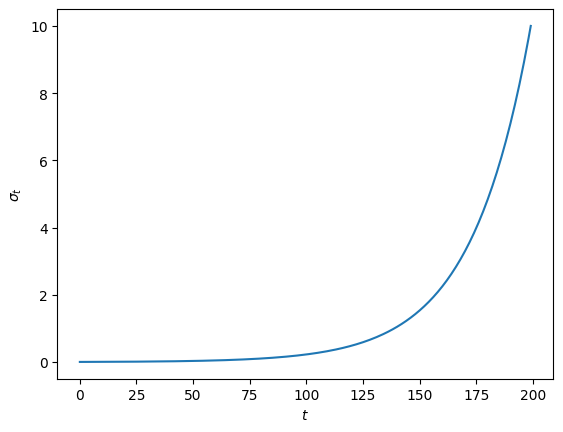

In [12]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process

schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
#plt.yscale('log')
print(schedule.sigmas)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_253384/2044932982.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_253384/2044932982.py:20: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


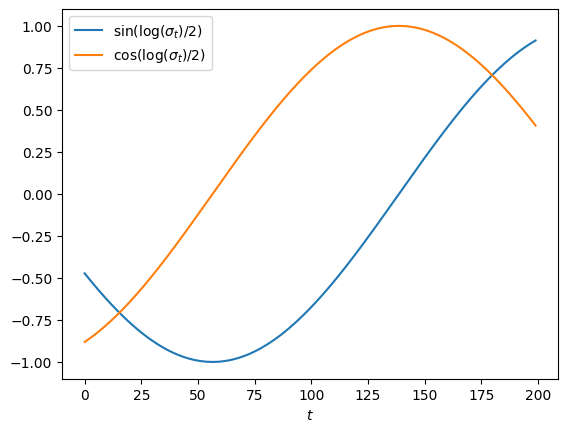

In [13]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""

# schedule.sigmas is essentially 1D. however, get_sigma_embeds takes it to 2D
# where the first D is "torch.sin(torch.log(sigma)/2)" and the second D is "torch.cos(torch.log(sigma)/2)"
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [14]:
# the next line is just creating the object
trainer  = training_loop(loader, model, schedule, epochs=15000)

losses   = [ns.loss.item() for ns in trainer]

100%|██████████| 15000/15000 [01:08<00:00, 219.47it/s]


1


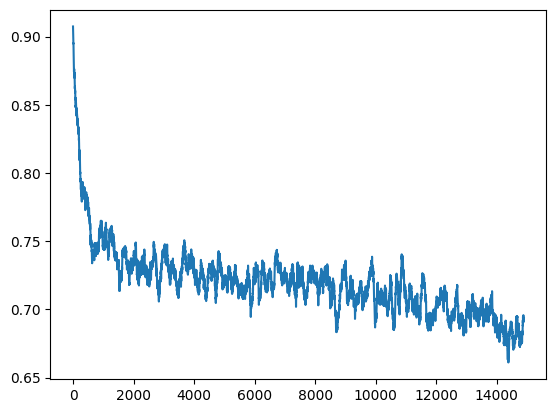

In [15]:
print(len(loader))
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

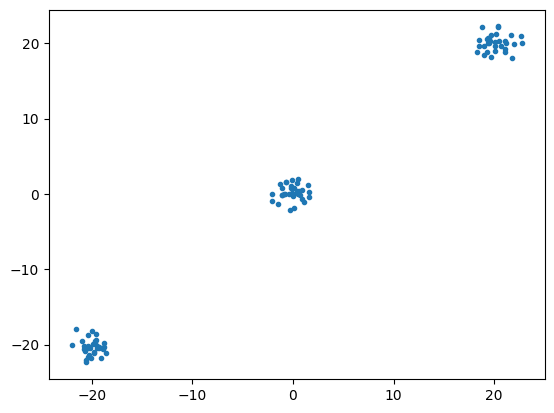

In [16]:
# all the instances in the data combined (plotted) together results
# in this 3 Gaussian shape. This is essentially the noiseless data that 
# represents the dataset.
plot_batch(next(iter(loader)), filename="Gauss3", save=False)

indices [np.int64(199), np.int64(159), np.int64(119), np.int64(79), np.int64(39)]
tensor([[ 19.2692,  14.8728],
        [  9.0072, -21.0552],
        [ -7.5813,  10.7832],
        [  8.0080,  16.8062],
        [  3.5586,  -6.8662],
        [ -4.9336,   2.4149],
        [ -2.3162,   0.4176],
        [ -2.5158,   8.5986],
        [ -3.0973,  -3.9571],
        [  8.0341,  -6.2160]])
tensor([[18.8063, 18.2564],
        [-4.7714, -5.6439],
        [-1.0810,  1.7000],
        [12.8029, 16.3459],
        [ 0.1258, -1.6530],
        [-2.0893,  0.4863],
        [-1.5545, -0.1598],
        [ 0.3809,  1.7744],
        [-1.5461, -1.5654],
        [ 1.1620, -1.1184]])
tensor([[19.1109, 19.3017],
        [-2.2819, -2.2184],
        [-0.6387,  0.4462],
        [17.5689, 18.3888],
        [-0.2777, -0.4971],
        [-0.8941,  0.0892],
        [-0.8036, -0.0868],
        [-0.1316,  0.5008],
        [-0.8103, -0.6549],
        [ 0.1492, -0.2177]])
tensor([[19.1278, 19.3919],
        [-1.8198, -1.6295],

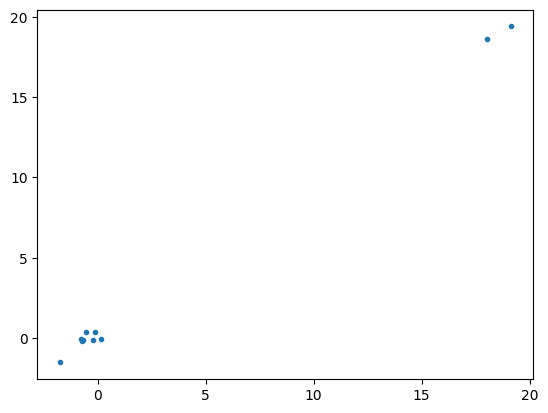

In [26]:
"""
1) Forward Diffusion Process:

Initial Steps: Start with the original data and add a small amount of noise.
Progressive Steps: Gradually increase the amount of noise added at each step.
Final Steps: Add significant noise, resulting in data that is almost entirely noise.
Purpose: This process creates a sequence of increasingly noisy data, which the model learns to reverse.

2) Reverse Diffusion Process:

Initial Steps: Start with the highly noisy data.
Progressive Steps: Gradually remove large amounts of noise initially.
Final Steps: As the data becomes less noisy, remove smaller amounts of noise to refine the output.
Purpose: This process reconstructs the original data from noise, step by step.
"""

# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
# schedule.sample_sigmas(15) this is the noise level generated for the reverse diffusion
# hence, it starts with high values and decreases quickly but then decreases lesser and lesser
# because as we approach to the real distrbution, we want to be careful not to remove a lot of noise
# because then it would be an overshoot.
xt = samples(model, schedule.sample_sigmas(5), mu=0, batchsize=10)

# convert it to a list
denoising_steps = list(xt)

plot_batch(denoising_steps[4], filename="gauss_animations/Gauss3_DDIM_50_v2", save=True)

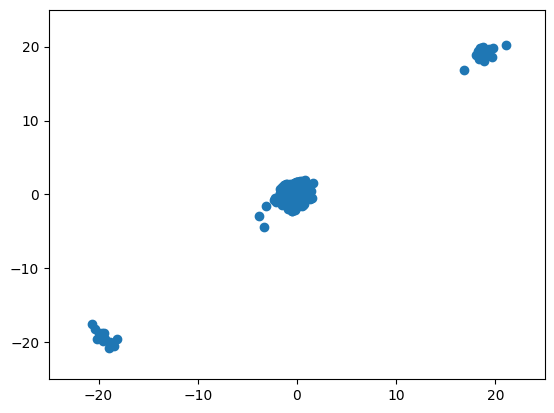

In [18]:
from animations import animate_diffusion_2


animate_diffusion_2(denoising_steps, filename="gauss_animations/Gauss3_DDIM_50_v2", save=True)

In [19]:
# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0

print(schedule.sample_sigmas(5))
xt_PM = samples(model, schedule.sample_sigmas(50), mu=0.5, batchsize=250)
denoising_steps_PM = list(xt_PM)

xt_IM = samples(model, schedule.sample_sigmas(50), mu=0, batchsize=250)
denoising_steps_IM = list(xt_IM)

animated_org = list(loader) * 51

indices [np.int64(199), np.int64(159), np.int64(119), np.int64(79), np.int64(39)]
tensor([1.0000e+01, 2.1701e+00, 4.7093e-01, 1.0219e-01, 2.2177e-02, 5.0000e-03])
indices [np.int64(199), np.int64(195), np.int64(191), np.int64(187), np.int64(183), np.int64(179), np.int64(175), np.int64(171), np.int64(167), np.int64(163), np.int64(159), np.int64(155), np.int64(151), np.int64(147), np.int64(143), np.int64(139), np.int64(135), np.int64(131), np.int64(127), np.int64(123), np.int64(119), np.int64(115), np.int64(111), np.int64(107), np.int64(103), np.int64(99), np.int64(95), np.int64(91), np.int64(87), np.int64(83), np.int64(79), np.int64(75), np.int64(71), np.int64(67), np.int64(63), np.int64(59), np.int64(55), np.int64(51), np.int64(47), np.int64(43), np.int64(39), np.int64(35), np.int64(31), np.int64(27), np.int64(23), np.int64(19), np.int64(15), np.int64(11), np.int64(7), np.int64(3)]
tensor([[ 1.9269e+01,  1.4873e+01],
        [ 9.0072e+00, -2.1055e+01],
        [ 6.7842e+00, -1.2345e+01

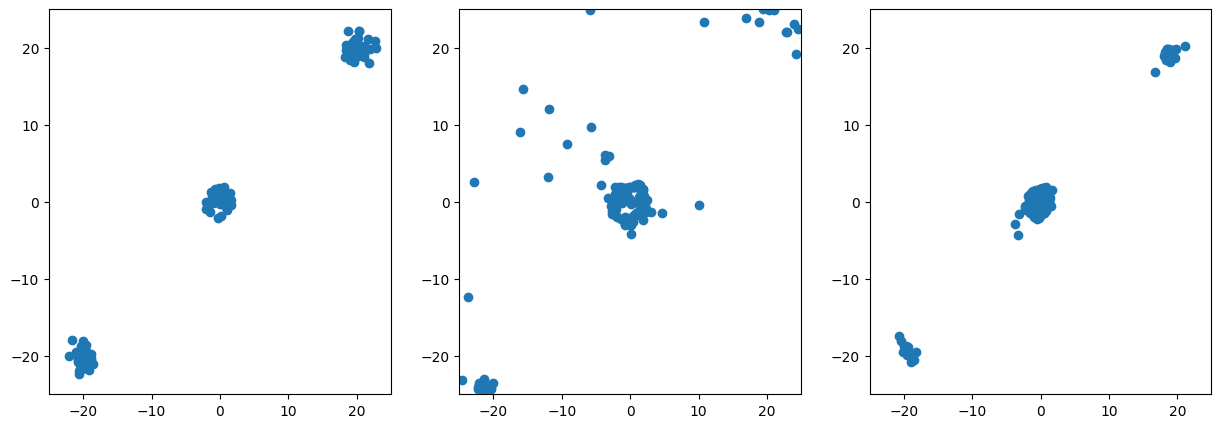

In [20]:
from animations import animate_diffusion_3, animate_diffusion_4


animate_diffusion_4(animated_org, denoising_steps_PM, denoising_steps_IM, filename="gauss_animations/combined", save=True, interval=300)